In [8]:
source("../methods_extRemes.r")

---
### **Fit GEV to each land surface cell**

In [13]:
# fit model to each grid cell (takes about 80s)
system.time({
    mle_gev = lapply(colnames(era5)[-(1:2)], function(cnm) {
        
        if(is.na(era5[1,cnm])) {
            return(NULL)
        } else {
            return(suppressWarnings(fevd(x=tmax, data=setNames(era5[,c("gmst",cnm)], c("gmst", "tmax")), location.fun=~gmst, type="GEV", optim.args = list(method = "Nelder-Mead"))))
        }
    })
})

   user  system elapsed 
 82.120   0.040  82.258 

In [14]:
# parameter estimates, event value, return period
ml_res <- data.frame(t(do.call("rbind", lapply(1:length(mle_gev), function(i) {
    if(is.null(mle_gev[[i]])) {
        return(setNames(rep(NA,11), c("mu0", "mu1", "sigma0", "shape", "ep", "rp", "rl10", "rl20", "pr", "delta_I", "nll")))
    } else {
        mdl <- mle_gev[[i]]
        pars <- model_pars(mdl)
        qc = event_qcov(mdl, event_gmst)
        ev = mdl$x[y]
        
        ep = unname(1-pextRemes(mdl, q = ev, qcov = qc))
        rp = 1/(ep)
        rl10 = unname(return_level(mdl, 10, event_gmst))
        rl20 = unname(return_level(mdl, 20, event_gmst))
        
        pr = prob_ratio(mdl, ev, event_gmst, event_gmst - 1.2)
        
        nll = mdl$results$value
        
        if(is.finite(rp)) {
            di = delta_I(mdl, rp, event_gmst, event_gmst - 1.2)
        } else {
            di = NA
        }
        
        return(c("mu0" = unname(pars["mu0"]), "mu1" = unname(pars["mu1"]), "scale" = unname(pars["scale"]), "shape" = unname(pars["shape"]), 
                 "ep" = ep, "rp" = rp, "rl10" = rl10, "rl20" = rl20, "pr" = pr, "delta_I" = di, "nll" = nll))
    }
}))))
write.csv(ml_res, "fitted-models/era5-eu_tx1x-jan_shift_ml-gev-ests.csv")

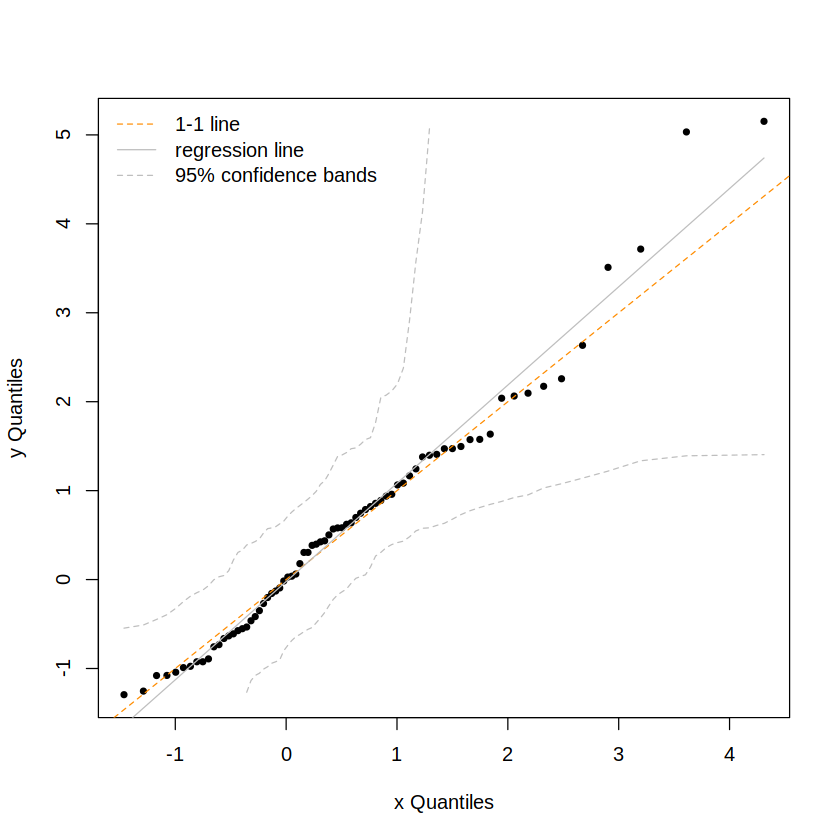

In [5]:
# quick fit test
mdl = mle_gev[[7251]]
x = seq(0,1,length.out = length(mdl$x)+2)[2:(length(mdl$x)+1)]
qqplot(qevd(x), trans(mdl))

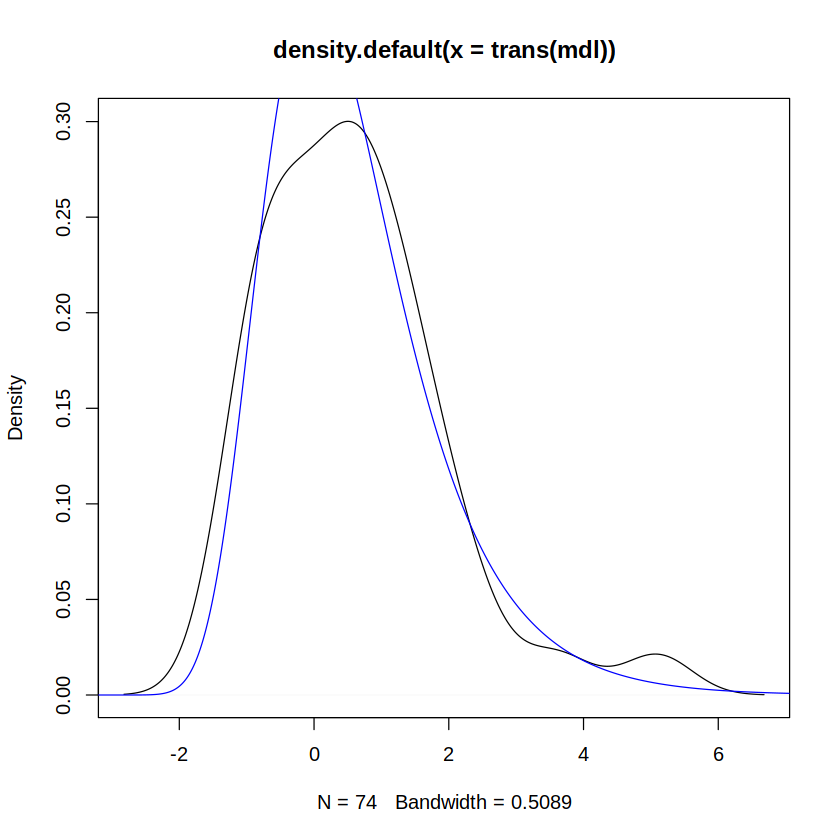

In [6]:
plot(density(trans(mdl)))
lines(seq(-4,8,0.01), devd(seq(-4,8,0.01)), col = "blue")